# Final Project Modeling
Questions:
- Is there a relationship between officer gender and baseline perceptions of police’s role in CAW cases?
- Does having a WHD impact the officers’ perceptions of police’s role in CAW cases? Can we predict change in perception based on treatment and other officer/station features?

Method:
- Q1: Hypothesis tests for gender and baseline perceptions
- Q1: Logistic regression predicting gender from baseline perceptions
- Q2: Hypothesis tests for treatment and change in perceptions
- Q2: Linear regression predicting change in one of the perceptions (decided based on hypothesis tests) utilizing officer and station level details


In [1]:
# import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn import metrics

In [2]:
# Set max display cols/rows

# See all columns
pd.set_option('display.max_columns', None)

# See up to 200 rows
pd.set_option('display.max_rows', 200)

In [3]:
# set up imports from google drive
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# root_dir is the path to your My_Drive folder.
root_dir = "/content/drive/My Drive/"

# i'm storing the data folder in the Colab Notebooks directory at the top level of the Google Drive
data_folder = root_dir + "Colab Notebooks/MPP Science Replication Package/Data/"

# change directory to the data folder
os.chdir(data_folder)

In [5]:
# Read in data
baseline_police = pd.read_csv(data_folder + "police_baseline_all.csv")
full_police = pd.read_csv(data_folder + "police_station_merge.csv")

In [6]:
baseline_police.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 54 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   b_uid                                          1950 non-null   int64  
 1   gender                                         1950 non-null   object 
 2   b_pol_impt                                     1950 non-null   bool   
 3   b_thana_impt                                   1950 non-null   bool   
 4   b_wcase                                        1948 non-null   object 
 5   b_effective                                    1943 non-null   object 
 6   b_helpful                                      1947 non-null   object 
 7   b_add_officer                                  1948 non-null   object 
 8   b_add_female                                   1949 non-null   object 
 9   b_female_better                                1947 

In [7]:
full_police.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Columns: 149 entries, uid to female_better_change
dtypes: bool(59), float64(62), int64(8), object(20)
memory usage: 812.6+ KB


In [8]:
full_police.head(1)

,uid,gender,e_wcase,e_effective,e_false_case,e_helpful,e_add_officer,e_add_female,e_female_better,e_taken_seriously,e_prof_dev,e_work_help,e_pol_impt,e_thana_impt,e_sensitivity,ps_code,population,urban,dist_urban,strat_pca,treatment,group,dist_id,implement_quality,training_score,comm_outreach_strength,regular_whd,women_whd,b_wcase,b_effective,b_pol_impt,b_thana_impt,b_sensitivity,b_helpful,b_female_better,b_add_officer,b_add_female,e_wcase_too little attention,e_wcase_too much attention,e_effective_ineffective,e_effective_very effective,e_effective_very ineffective,e_false_case_uncommon,e_false_case_very common,e_false_case_very uncommon,e_taken_seriously_disagree,e_taken_seriously_strongly agree,e_taken_seriously_strongly disagree,e_prof_dev_disagree,e_prof_dev_strongly agree,e_prof_dev_strongly disagree,e_work_help_disagree,e_work_help_strongly agree,e_work_help_strongly disagree,e_helpful_unhelpful,e_helpful_very helpful,e_helpful_very unhelpful,e_add_officer_more effective,e_add_officer_much more effective,e_add_female_More Effective,e_add_female_Much more effective,e_add_female_No difference,e_female_better_male,e_female_better_no difference,urban_Urban,treatment_Treatment,orig_b_uid,orig_b_pol_impt,orig_b_thana_impt,orig_b_wcase,orig_b_effective,orig_b_helpful,orig_b_add_officer,orig_b_add_female,orig_b_female_better,orig_b_sensitivity,orig_b_wcase_too little attention,orig_b_wcase_too much attention,orig_b_effective_ineffective,orig_b_effective_neither effective nor ineffective,orig_b_effective_very effective,orig_b_effective_very ineffective,orig_b_helpful_neither helpful nor unhelpful,orig_b_helpful_unhelpful,orig_b_helpful_very helpful,orig_b_helpful_very unhelpful,orig_b_add_officer_more effective,orig_b_add_officer_much less effective,orig_b_add_officer_much more effective,orig_b_add_officer_no difference,orig_b_add_female_more effective,orig_b_add_female_much less effective,orig_b_add_female_much more effective,orig_b_add_female_no difference,orig_b_female_better_male,orig_b_female_better_no difference,orig_uid,e_total_surveyed,e_female_surveyed,e_male_surveyed,e_total_staff,e_female_staff,e_total_officers,e_female_officers,e_male_staff,e_male_officers,e_female_sho,b_total_staff,b_female_staff,b_male_staff,b_total_officers,b_female_officers,b_male_officers,b_female_sho,e_total_sampled,e_female_sampled,e_male_sampled,b_total_sampled,b_female_sampled,b_male_sampled,b_total_surveyed,b_female_surveyed,b_male_surveyed,e_male_weight,b_male_weight,e_female_weight,b_female_weight,e_wcase_num,e_effective_num,e_false_case_num,e_helpful_num,e_add_officer_num,e_add_female_num,e_female_better_num,e_taken_seriously_num,e_prof_dev_num,e_work_help_num,b_wcase_num,b_effective_num,b_helpful_num,b_add_officer_num,b_add_female_num,b_female_better_num,wcase_change,effective_change,helpful_change,add_officer_change,add_female_change,female_better_change
0,2141733,male,too much attention,very effective,uncommon,very helpful,much more effective,Less effective,female,strongly agree,agree,agree,True,True,8.0,2011,58432,Rural,2.0,-1.332458,Treatment,women officers,2000,9.0,3.77907,2.16,False,True,2.0,5.0,False,False,8.0,4.0,3.0,4.0,5.0,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,2141762,False,False,enough attention,very effective,helpful,more effective,much less effective,female,8.0,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,2141733,12.0,0.0,12.0,43.0,3.0,10.0,1.0,40.0,9.0,False,24.0,0.0,24.0,7.0,0.0,7.0,False,12.0,0.0,12.0,12.0,0.0,12.0,12.0,0.0,12.0,3.333333,2.0,NaN,NaN,3.0,5.0,2.0,5.0,5.0,4.0,3.0,4.0,3.0,3.0,2.0,5.0,4.0,4,5,3.0,1.0,0.0,1.0,1.0,-1.0,0.0


## Q1: Is there a relationship between officer gender and baseline perceptions of police’s role in CAW cases?

### Baseline data relevant variables

Reminder of number to answer mapping:
- wcase = {'not enough attention':1,'too little attention':1, 'enough attention':2, 'too much attention':3}
- effective = {'very ineffective':1, 'ineffective':2, 'neither effective nor ineffective':3, 'effective':4, 'very effective':5}
- false_case = {'very uncommon':1, 'uncommon':2, 'common':3, 'very common':4}
- helpful = {'very unhelpful':1, 'unhelpful':2, 'neither helpful nor unhelpful':3, 'helpful':4, 'very helpful':5}
- add_officer = {'much less effective':1, 'less effective':2, 'no difference':3, 'more effective':4, 'much more effective':5}
- add_female = {'much less effective':5, 'less effective':4, 'no difference':3, 'more effective':2, 'much more effective':1}
- female_better = {'male':1, 'no difference':2, 'female':3}
- taken_seriously = {'strongly disagree':1, 'disagree':2, 'agree':3, 'strongly agree':4}
- prof_dev = {'strongly disagree':1, 'disagree':2, 'agree':3, 'strongly agree':4}
- work_help = {'strongly disagree':1, 'disagree':2, 'agree':3, 'strongly agree':4}


In [9]:
# get list of columns with possible numeric y variables
baseline_nums = ['b_pol_impt', 'b_thana_impt', 'b_wcase_num', 'b_effective_num', 'b_helpful_num', 'b_add_officer_num', 'b_add_female_num', 'b_female_better_num', 'b_sensitivity']
baseline_police[baseline_nums].describe()

,b_wcase_num,b_effective_num,b_helpful_num,b_add_officer_num,b_add_female_num,b_female_better_num,b_sensitivity
count,1948.000000,1943.000000,1947.000000,1948.000000,1949.000000,1947.000000,1945.00000
mean,2.675051,4.592898,4.600924,4.433265,4.526937,2.712892,7.03856
std,0.482518,0.569108,0.551052,0.627369,0.670528,0.601688,2.45181
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
25%,2.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.00000
50%,3.000000,5.000000,5.000000,4.000000,5.000000,3.000000,7.00000
75%,3.000000,5.000000,5.000000,5.000000,5.000000,3.000000,8.00000
max,3.000000,5.000000,5.000000,5.000000,5.000000,3.000000,16.00000


### Permutation hypothesis testing
- Null Hypothesis: There's no systematic difference between the gender groups at baseline; both genders should have the same mean in their baseline perceptions of police
- Alternative hypothesis: there's a difference in the mean perceptions of police at baseline betweeen genders
- test statistic = difference in means

In [10]:
summary_df = pd.DataFrame()
summary_df['variable'] = pd.DataFrame(baseline_nums)
summary_df[['male_mean', 'female_mean', 'true_baseline_difference', 'p-value']] = np.nan
summary_df = summary_df.set_index('variable')
summary_df.head()

,male_mean,female_mean,true_baseline_difference,p-value
variable,,,,
b_pol_impt,NaN,NaN,NaN,NaN
b_thana_impt,NaN,NaN,NaN,NaN
b_wcase_num,NaN,NaN,NaN,NaN
b_effective_num,NaN,NaN,NaN,NaN
b_helpful_num,NaN,NaN,NaN,NaN


True baseline difference: -0.3783945554102286


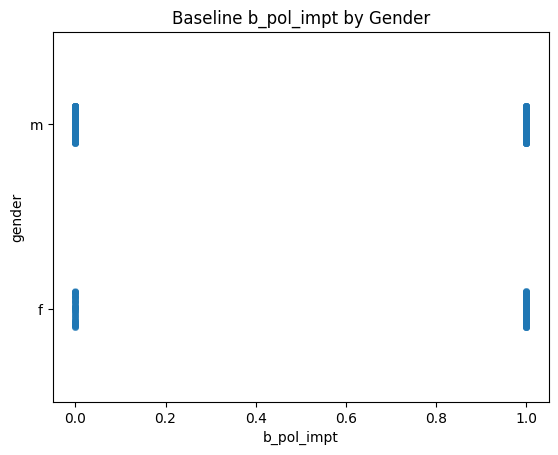

True baseline difference: -0.07080626925890621


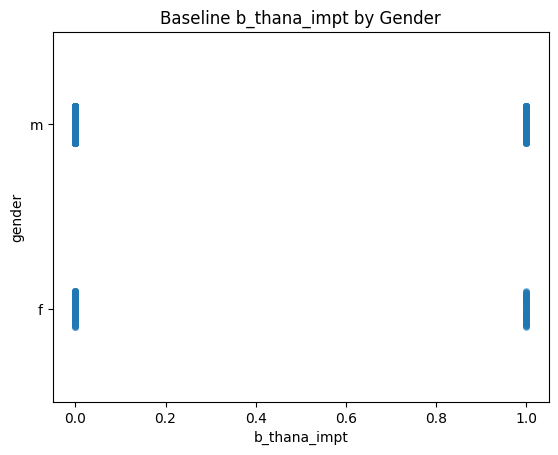

True baseline difference: 0.05278083978821568


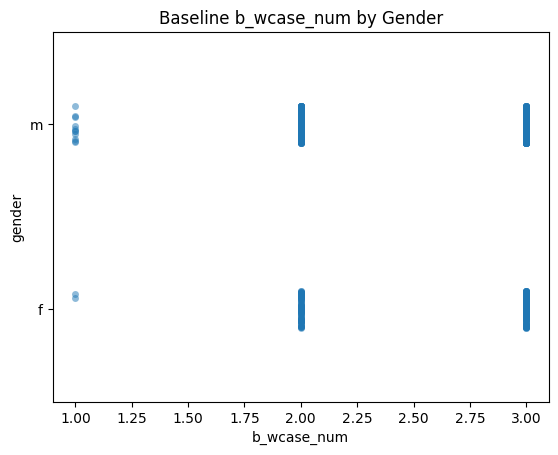

True baseline difference: -0.010013603010534666


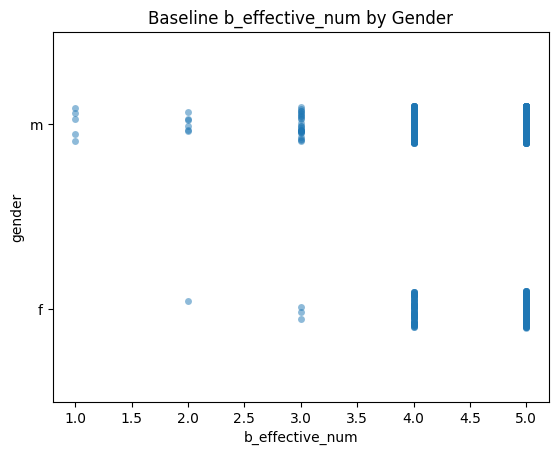

True baseline difference: 0.07627118644067821


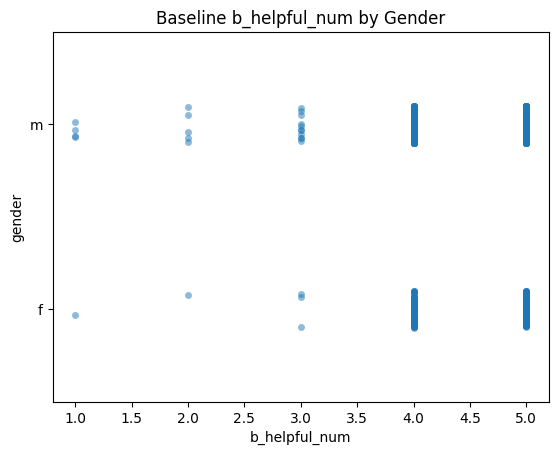

True baseline difference: 0.05132340502136845


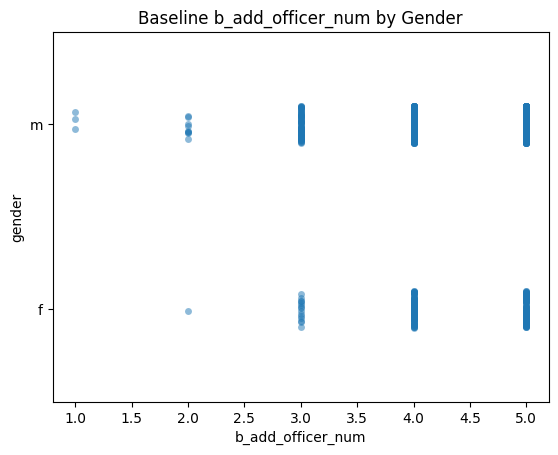

True baseline difference: -0.12544855869711036


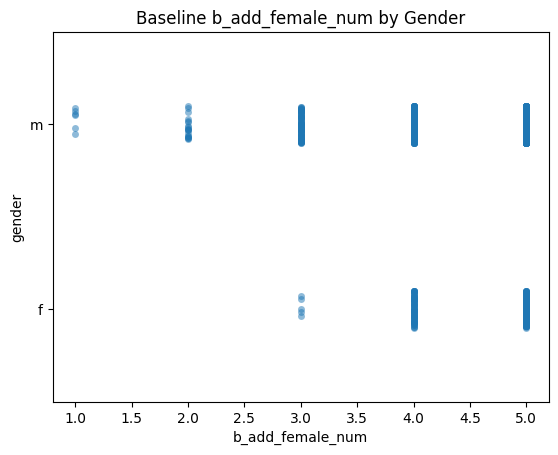

True baseline difference: -0.09629876378710467


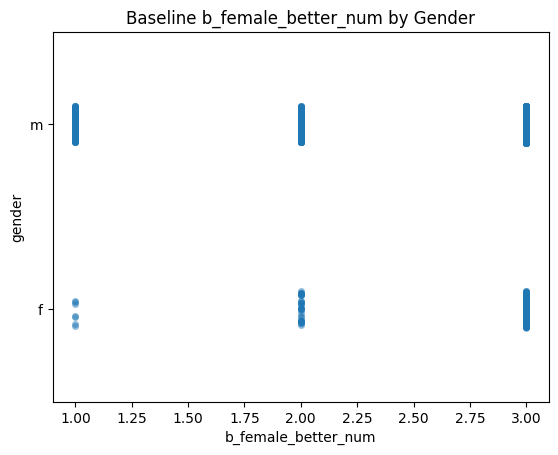

True baseline difference: -0.4885529426402879


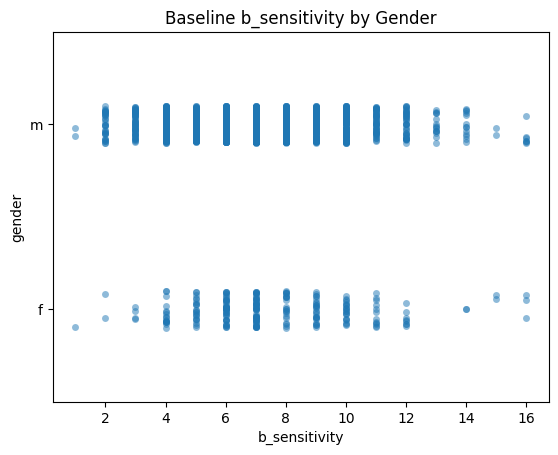

In [11]:
for var in baseline_nums:
  true_baseline_difference = baseline_police[baseline_police['gender'] == "m"][var].mean() - \
                             baseline_police[baseline_police['gender'] == "f"][var].mean()
  print("True baseline difference:", true_baseline_difference)
  sns.stripplot(x = var, y = 'gender', data = baseline_police, alpha = 0.5)
  plt.title(f"Baseline {var} by Gender")
  plt.show()
  summary_df.loc[var,'male_mean'] = baseline_police[baseline_police['gender'] == "m"][var].mean()
  summary_df.loc[var,'female_mean'] = baseline_police[baseline_police['gender'] == "f"][var].mean()
  summary_df.loc[var,'true_baseline_difference'] = true_baseline_difference

Fake baseline difference: 0.05869486503062954


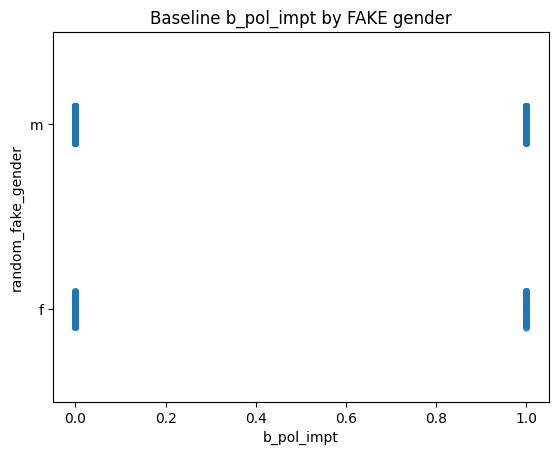

Fake baseline difference: 0.006044617851574341


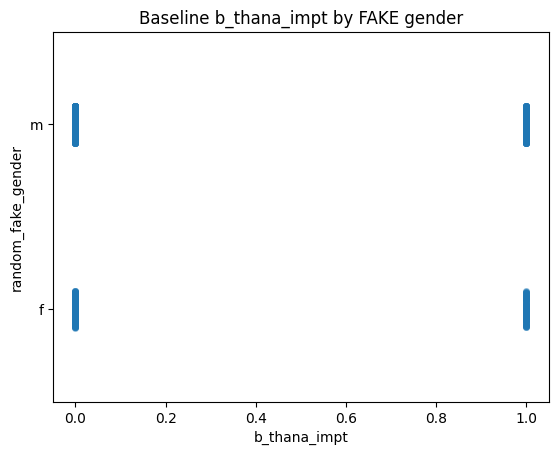

Fake baseline difference: -0.04329641658467054


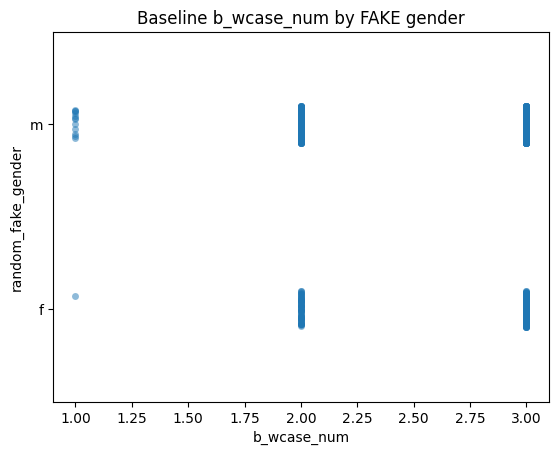

Fake baseline difference: 0.01209432086307416


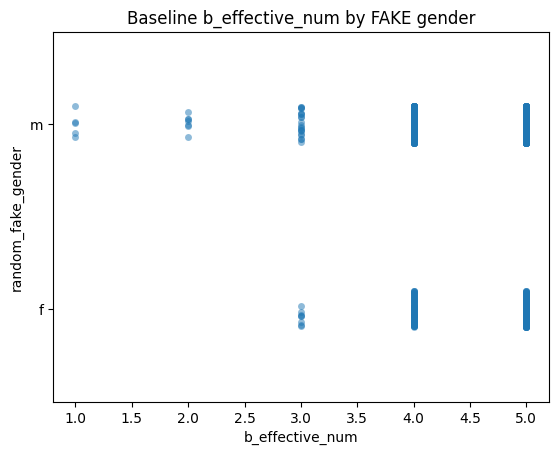

Fake baseline difference: 0.13895382817066082


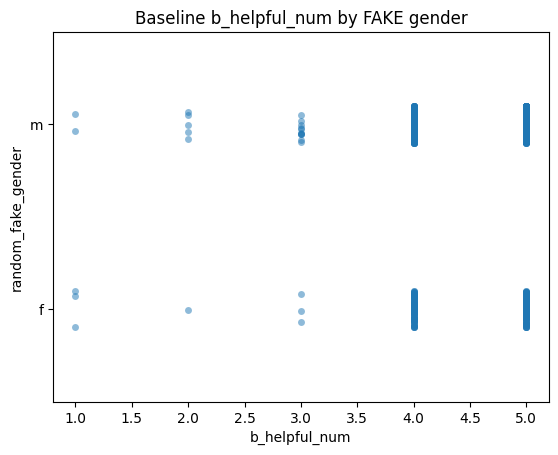

Fake baseline difference: 0.015672025978139992


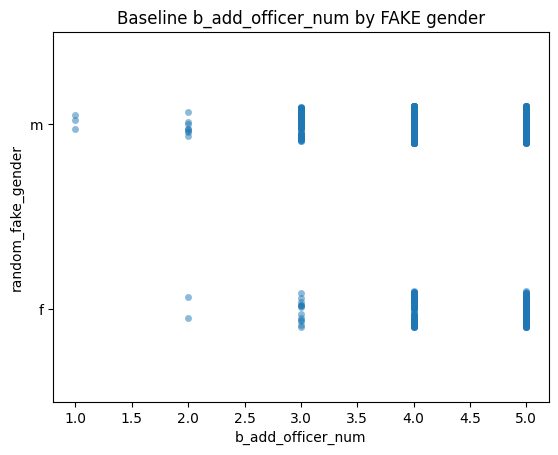

Fake baseline difference: -0.019771087187980818


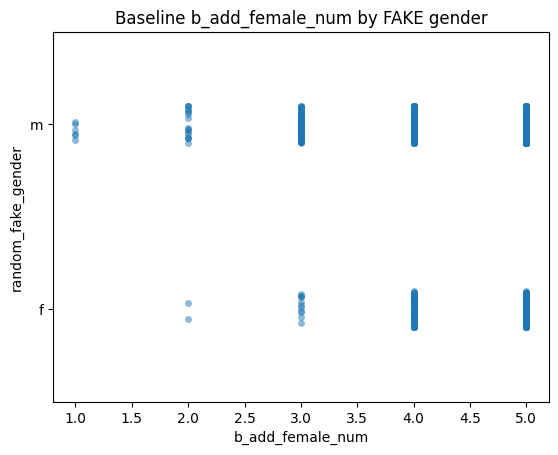

Fake baseline difference: 0.054208065458796195


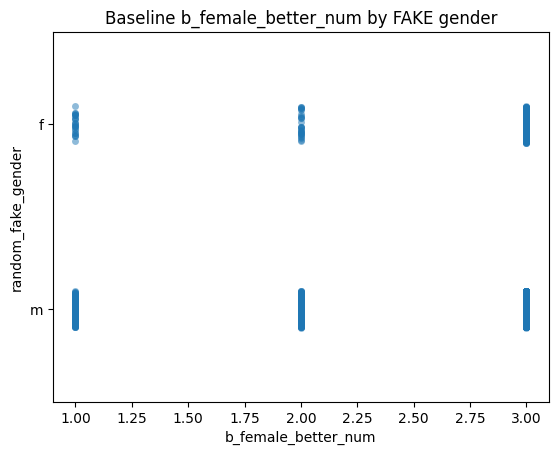

Fake baseline difference: 0.039106117649383876


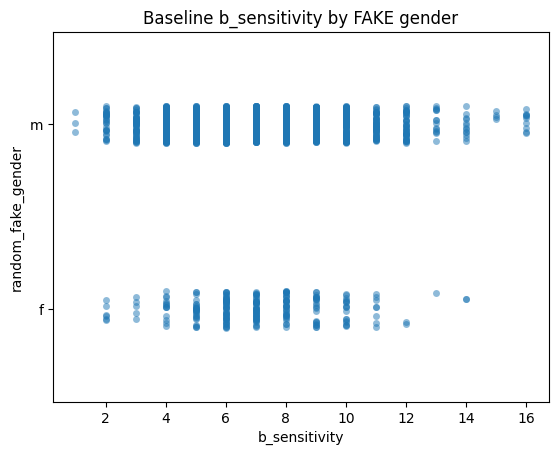

In [12]:
for var in baseline_nums:
  # We'll add a new column where we randomly reshuffle the treatment assignments to a different arrangement
  # Keeping the same total number of participants in each of the groups by reshuffling the existing treatment labels
  baseline_police['random_fake_gender'] = np.random.permutation(baseline_police['gender'])

  # Calculate the baseline difference between these FAKE GROUPS, as before
  fake_baseline_difference = baseline_police[baseline_police['random_fake_gender'] == "m"][var].mean() - \
                             baseline_police[baseline_police['random_fake_gender'] == "f"][var].mean()
  print("Fake baseline difference:", fake_baseline_difference)

  # We can even plot this randomly reshuffled baseline comparison, as before
  sns.stripplot(x = var, y = 'random_fake_gender', data = baseline_police, alpha = 0.5)
  plt.title(f"Baseline {var} by FAKE gender")
  plt.show()

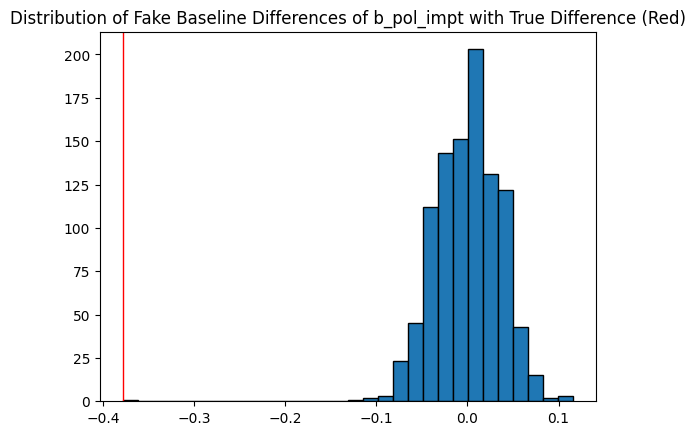

P-value for baseline difference: 0.001


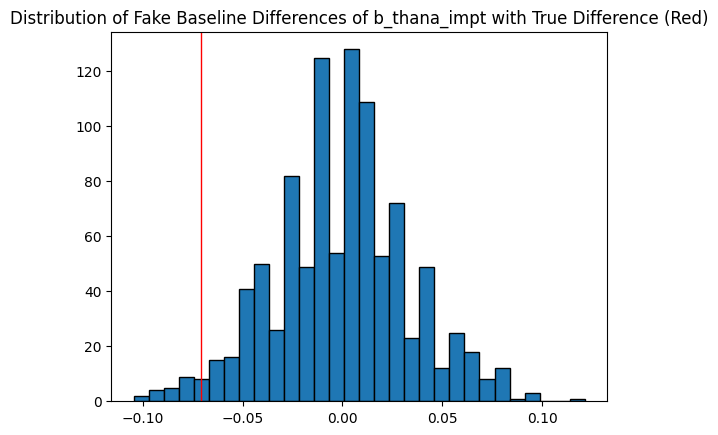

P-value for baseline difference: 0.053


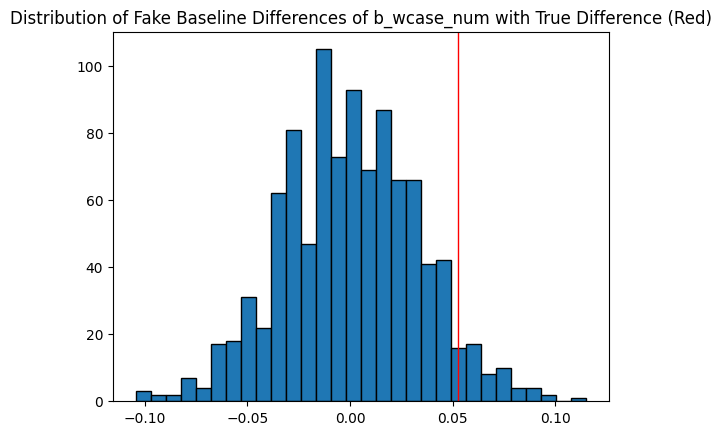

P-value for baseline difference: 0.118


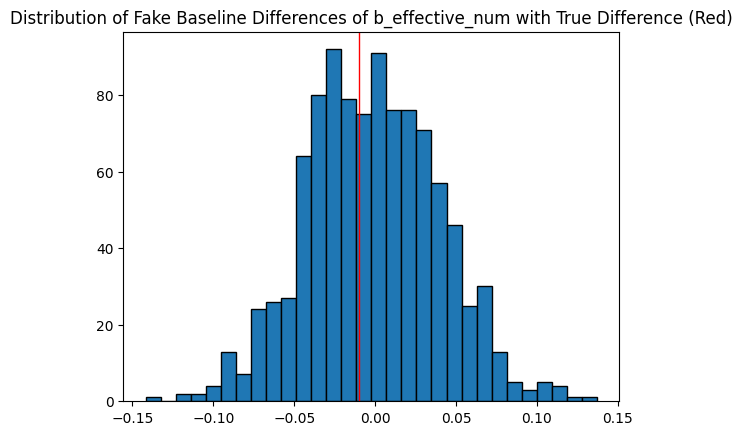

P-value for baseline difference: 0.814


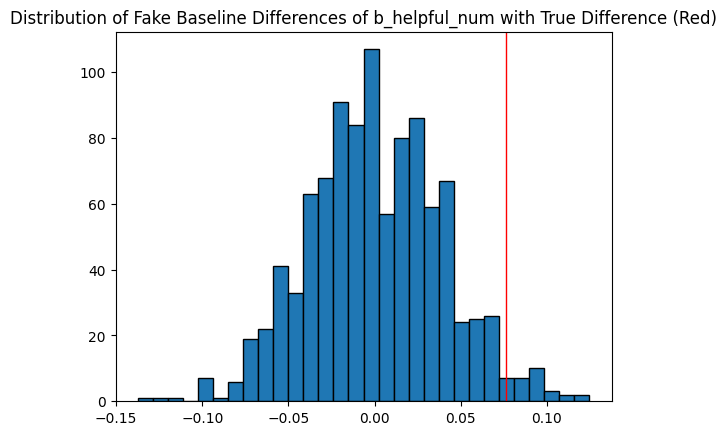

P-value for baseline difference: 0.046


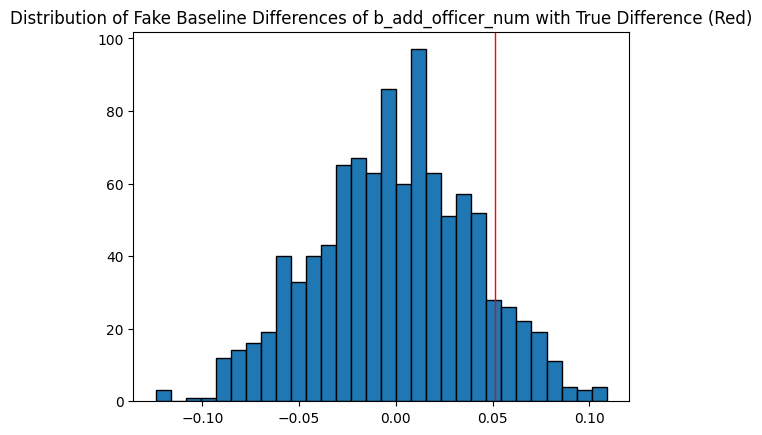

P-value for baseline difference: 0.222


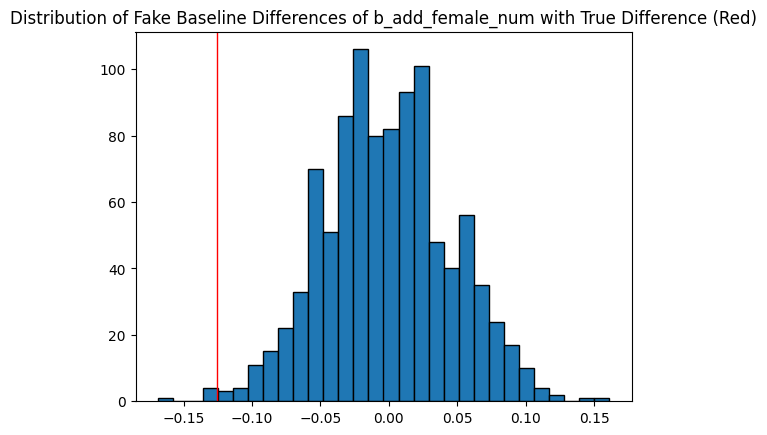

P-value for baseline difference: 0.007


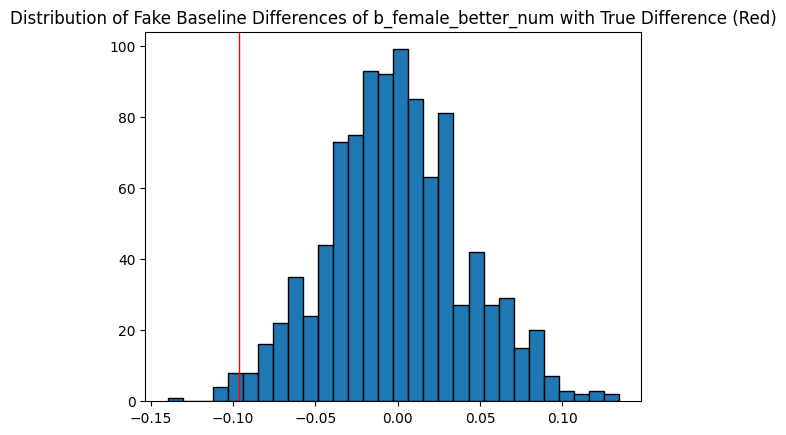

P-value for baseline difference: 0.023


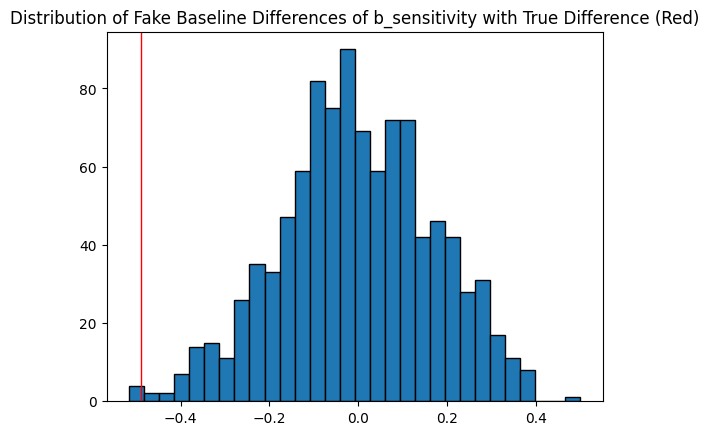

P-value for baseline difference: 0.005


In [13]:

for var in baseline_nums:
  vector_of_differences = np.empty(1000)    # Make an empty vector to store all our differences
  true_baseline_difference = baseline_police[baseline_police['gender'] == "m"][var].mean() - \
                             baseline_police[baseline_police['gender'] == "f"][var].mean()

  for i in range(999):
     # Permute the gender labels
     baseline_police['random_fake_gender'] = np.random.permutation(baseline_police['gender'])
     # Calculate the fake difference and store it in the "ith" spot in the vector
     vector_of_differences[i] = baseline_police[baseline_police['random_fake_gender'] == "m"][var].mean() - \
                                baseline_police[baseline_police['random_fake_gender'] == "f"][var].mean()

  # Add real difference to the end of the list
  vector_of_differences[999] = true_baseline_difference

  # Plot the distribution of real and fake differences
  plt.hist(vector_of_differences, bins = 30, edgecolor = 'black') # Set up a histogram
  plt.axvline(x = true_baseline_difference, color = 'red', linewidth = 1) # Add a vertical red line
  plt.title(f"Distribution of Fake Baseline Differences of {var} with True Difference (Red)")
  plt.show()
  p_value = (np.abs(vector_of_differences) >= np.abs(true_baseline_difference)).mean()
  print("P-value for baseline difference:", p_value)
  summary_df.loc[var, 'p-value'] = p_value

In [14]:
summary_df

,male_mean,female_mean,true_baseline_difference,p-value
variable,,,,
b_pol_impt,0.347344,0.725738,-0.378395,0.001
b_thana_impt,0.397548,0.468354,-0.070806,0.053
b_wcase_num,2.681473,2.628692,0.052781,0.118
b_effective_num,4.591681,4.601695,-0.010014,0.814
b_helpful_num,4.610169,4.533898,0.076271,0.046
b_add_officer_num,4.439509,4.388186,0.051323,0.222
b_add_female_num,4.511682,4.637131,-0.125449,0.007
b_female_better_num,2.701170,2.797468,-0.096299,0.023
b_sensitivity,6.979532,7.468085,-0.488553,0.005


### Interpreting results of the permutation tests
- _Baseline index for perceptions of tasks most important to the officer_
 - When we ran our permutation test, we only found a difference as extreme (or more extreme) as our observed result 0.1% of the time, giving us a p-value of 0.001, which falls below a typical decision threshold of 5%. Therefore, we have evidence to **reject the null hypothesis** of no difference between genders, in favor of the alternative: that there is a statistically significant difference in baseline perception of womens cases being most important to the officer between genders.
 - Looking at the difference in means, female officers list women's cases as an issue most important to the officer **MORE** than male officers
- _Baseline index for perceptions of tasks most important to the station_
 - When we ran our permutation test, we only found a difference as extreme (or more extreme) as our observed result 3.5% of the time, giving us a p-value of 0.035, which falls below a typical decision threshold of 5%. Therefore, we have evidence to **reject the null hypothesis** of no difference between genders, in favor of the alternative: that there is a statistically significant difference in baseline perception of womens cases being most important to the station between genders.
  - Looking at the difference in means, female officers list women's cases as an issue most important to the station **MORE** than male officers
- _Baseline index for police’s attention to women’s cases_
 - When we ran our permutation test, we found a difference as extreme (or more extreme) as our observed result 13.4% of the time, giving us a p-value of 0.134, which falls above a typical decision threshold of 5%. Therefore, we **fail to reject the null hypothesis** of no difference in baseline perception of police's attention to women's cases between genders.
- _Baseline index for perception of police’s effectiveness in dealing with cases related to women_
 - When we ran our permutation test, we found a difference as extreme (or more extreme) as our observed result 83.0% of the time, giving us a p-value of 0.830, which falls above a typical decision threshold of 5%. Therefore, we **fail to reject the null hypothesis** of no difference in baseline perception of police’s effectiveness in dealing with cases related to women between genders.
- _Baseline index for perceptions of police’s helpfulness_
 - When we ran our permutation test, we only found a difference as extreme (or more extreme) as our observed result 4.9% of the time, giving us a p-value of 0.049, which falls just below a typical decision threshold of 5%. Therefore, we have evidence to **reject the null hypothesis** of no difference between genders, in favor of the alternative: that there is a statistically significant difference in baseline perception of police's helpfulness between genders.
  - Looking at the difference in means, female officers perceive the police to be **LESS** helpful than male officers
- _Baseline index corresponding to the survey question “Will hiring more officers make police more effective in women’s cases?”_
 - When we ran our permutation test, we found a difference as extreme (or more extreme) as our observed result 25.2% of the time, giving us a p-value of 0.252, which falls above a typical decision threshold of 5%. Therefore, we **fail to reject the null hypothesis** of no difference in baseline perception of efficacy of hiring more officers between genders.
- _Baseline index corresponding to the survey question “Will hiring more female officers make police more effective in women’s cases”_
 - When we ran our permutation test, we only found a difference as extreme (or more extreme) as our observed result 0.9% of the time, giving us a p-value of 0.009, which falls below a typical decision threshold of 5%. Therefore, we have evidence to **reject the null hypothesis** of no difference between genders, in favor of the alternative: that there is a statistically significant difference in baseline perception of efficacy of hiring more female officers between genders.
- _Baseline index corresponding to the survey question “Who is more effective in handling cases related to women?”_
 - When we ran our permutation test, we only found a difference as extreme (or more extreme) as our observed result 1.5% of the time, giving us a p-value of 0.015, which falls below a typical decision threshold of 5%. Therefore, we have evidence to **reject the null hypothesis** of no difference between genders, in favor of the alternative: that there is a statistically significant difference in baseline perception of which gender is more effective in handling women's cases between genders.
 - Looking at the difference in means, female officers perceive the female officers to be better at handling women's cases **MORE** than male officers do.
- _Baseline index for perceptions of police’s sensitivity in dealing with cases related to women_
 - When we ran our permutation test, we only found a difference as extreme (or more extreme) as our observed result 0.4% of the time, giving us a p-value of 0.0004, which falls below a typical decision threshold of 5%. Therefore, we have evidence to **reject the null hypothesis** of no difference between genders, in favor of the alternative: that there is a statistically significant difference in baseline perception of police's sensitivity in dealing with women's cases between genders.


### Perform a logistic regression predicting gender of the officer from the significant variables from the hypothesis test
- Logistic regression because we are classifying officers into 2 groups (male and female)

In [15]:
# Create list of variables with statistically significant difference in baseline perception
sig_vars = ['b_pol_impt', 'b_thana_impt', 'b_helpful_num', 'b_add_female_num', 'b_female_better_num', 'b_sensitivity']
# Create dataset that has gender and what will be our x variables - check for any missing values
baseline_sig_vars = baseline_police[['gender'] + sig_vars]
print(len(baseline_sig_vars))
baseline_sig_vars.isnull().sum()

1950


,0
gender,0
b_pol_impt,0
b_thana_impt,0
b_helpful_num,3
b_add_female_num,1
b_female_better_num,3
b_sensitivity,5


In [16]:
# Drop rows with null values
baseline_sig_vars = baseline_sig_vars.dropna(axis=0)
print(len(baseline_sig_vars))
baseline_sig_vars.isnull().sum()
# only lose 9 records out of 1950

1941


,0
gender,0
b_pol_impt,0
b_thana_impt,0
b_helpful_num,0
b_add_female_num,0
b_female_better_num,0
b_sensitivity,0


In [17]:
# source of function: logistic regression overview notebook
def standardize(data):
  """
  given a column of data, return a new column with all values standardized
  using z-score normalization.

  Arguments:
    data: Pandas column

  Return:
    Pandas column with values z-score standardized
  """
  mean = np.mean(data)
  std = np.std(data)

  standardized_data = (data - mean) / std
  return standardized_data

In [18]:
# Split into x and y variables

X = baseline_sig_vars.drop(columns="gender")

# y will hold the outcomes
y = baseline_sig_vars["gender"]

print("Shape of X:", X.shape, " Shape of y:", y.shape)


Shape of X: (1941, 6)  Shape of y: (1941,)


In [24]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [25]:
X_train.head()

,b_pol_impt,b_thana_impt,b_helpful_num,b_add_female_num,b_female_better_num,b_sensitivity
252,True,True,5.0,4.0,2.0,7.0
245,False,False,4.0,4.0,2.0,11.0
116,False,False,4.0,4.0,3.0,6.0
1572,True,False,5.0,4.0,3.0,4.0
1928,True,True,5.0,5.0,3.0,11.0


In [26]:
def do_standardize(df):
  # create a standardized copy of the dataframe
  df_standardized = df.copy()

  # standardize all columns in X data
  for column in df_standardized.iloc[:,:]:
   df_standardized[column] = standardize(df_standardized[column])
  print(df_standardized.head())
  return df_standardized


In [27]:
# standardize both X datasets
X_train = do_standardize(X_train)
X_test = do_standardize(X_test)

      b_pol_impt  b_thana_impt  b_helpful_num  b_add_female_num  \
252     1.257676      1.206522       0.715051         -0.814148   
245    -0.795117     -0.828828      -1.089855         -0.814148   
116    -0.795117     -0.828828      -1.089855         -0.814148   
1572    1.257676     -0.828828       0.715051         -0.814148   
1928    1.257676      1.206522       0.715051          0.710835   

      b_female_better_num  b_sensitivity  
252             -1.195417      -0.029167  
245             -1.195417       1.571184  
116              0.473007      -0.429255  
1572             0.473007      -1.229430  
1928             0.473007       1.571184  
     b_pol_impt  b_thana_impt  b_helpful_num  b_add_female_num  \
229    1.203985     -0.818833       0.738784          0.695919   
67    -0.830575     -0.818833       0.738784         -0.722685   
773    1.203985      1.221251       0.738784          0.695919   
532   -0.830575     -0.818833       0.738784         -0.722685   
25    -0.

In [28]:
# create an instance of LogisticRegression. set the random_state for reproducibility
model = LogisticRegression(random_state=24)

# train the model on the training data
model.fit(X_train, y_train)

LogisticRegression(random_state=24)

In [29]:
# call predict on the test data to generate predictions
predictions = model.predict(X_test)
predictions

array(['m', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm',
       'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm',
       'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm',
       'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm',
       'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm',
       'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm',
       'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm',
       'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm',
       'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm',
       'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm',
       'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm',
       'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm',
       'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm',
       'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm

In [30]:
y_test.value_counts()

,count
gender,
m,513
f,70


In [31]:
unique, counts = np.unique(predictions, return_counts=True)
print(np.asarray((unique, counts)).T)

[['m' 583]]


In [32]:
y_train.value_counts()

,count
gender,
m,1193
f,165


The model is only predicting male officers
- Why? The training data is so heavily weighted towards men that the model is only predicting men as the outcome because it is correct most of the time
- How can we fix it?
 - oversampling
 - try a new model type (ex: random forest or xgboost)
 - set class weight parameter to 'balanced' rather than the default **(I chose this)**

In [33]:
# create an instance of LogisticRegression. set the random_state for reproducibility, set class weight = 'balanced'
model2 = LogisticRegression(random_state=24, class_weight='balanced')

# train the model on the training data
model2.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=24)

In [34]:
# call predict on the test data to generate predictions
predictions2 = model2.predict(X_test)
predictions2

array(['f', 'm', 'f', 'm', 'm', 'm', 'm', 'm', 'f', 'f', 'f', 'm', 'f',
       'm', 'm', 'm', 'f', 'm', 'f', 'm', 'm', 'm', 'm', 'm', 'm', 'm',
       'm', 'm', 'f', 'm', 'f', 'm', 'm', 'f', 'f', 'm', 'm', 'f', 'm',
       'f', 'f', 'm', 'f', 'm', 'f', 'm', 'f', 'm', 'm', 'f', 'f', 'm',
       'm', 'f', 'm', 'f', 'm', 'f', 'm', 'm', 'm', 'f', 'm', 'm', 'm',
       'm', 'm', 'm', 'm', 'm', 'f', 'm', 'm', 'm', 'f', 'f', 'm', 'f',
       'm', 'f', 'm', 'f', 'm', 'f', 'm', 'f', 'm', 'm', 'f', 'm', 'm',
       'm', 'm', 'f', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'f', 'm', 'm',
       'm', 'm', 'f', 'm', 'm', 'm', 'f', 'f', 'm', 'm', 'm', 'm', 'm',
       'm', 'f', 'f', 'm', 'f', 'f', 'f', 'f', 'm', 'm', 'm', 'm', 'f',
       'f', 'm', 'm', 'm', 'f', 'f', 'm', 'm', 'm', 'f', 'm', 'm', 'm',
       'f', 'm', 'f', 'm', 'f', 'f', 'm', 'm', 'f', 'm', 'm', 'm', 'f',
       'm', 'm', 'm', 'm', 'm', 'm', 'm', 'f', 'm', 'm', 'm', 'f', 'f',
       'm', 'm', 'm', 'm', 'm', 'm', 'f', 'm', 'f', 'm', 'f', 'm

In [35]:
y_test.value_counts()

,count
gender,
m,513
f,70


In [36]:
unique, counts = np.unique(predictions2, return_counts=True)
print(np.asarray((unique, counts)).T)

[['f' 227]
 ['m' 356]]


In [37]:
# generate the confusion matrix
confusion_matrix(y_test, predictions2)

array([[ 48,  22],
       [179, 334]])

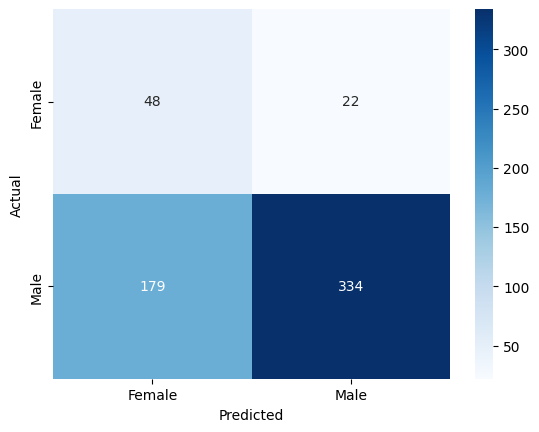

In [38]:
class_names = ["Female", "Male"]

_ = sns.heatmap(
    confusion_matrix(y_test, predictions2),
    annot=True,   # annotate the map with the matrix values
    fmt='g',      # this gets us integers for the annotated numbers
    cmap='Blues', # blue color map
    xticklabels=class_names,
    yticklabels=class_names
    )
_ = plt.xlabel('Predicted')
_ = plt.ylabel('Actual')

In [39]:
# generate the classification report
class_names = ["Female", "Male"]
print(classification_report(y_test, predictions2, target_names=class_names))


              precision    recall  f1-score   support

      Female       0.21      0.69      0.32        70
        Male       0.94      0.65      0.77       513

    accuracy                           0.66       583
   macro avg       0.57      0.67      0.55       583
weighted avg       0.85      0.66      0.72       583



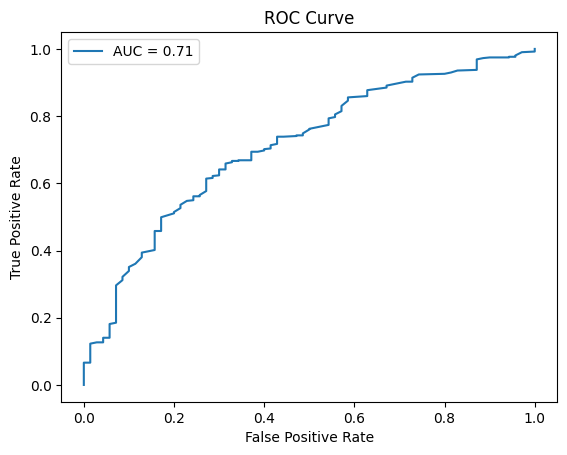

In [40]:
# predict the probabilities of the test data
y_pred_probability = model2.predict_proba(X_test)[::, 1]

# compute the false positive rate and true positive rate
false_pos_rate, true_pos_rate, _ = metrics.roc_curve(y_test, y_pred_probability, pos_label='m')

# AUC scores give us good info about the classifier's worth
auc = metrics.roc_auc_score(y_test, y_pred_probability)

plt.plot(false_pos_rate, true_pos_rate, label="AUC = " + "%.2f" % auc)


#_ = plt.plot([0, 1], [0, 1], 'k--')
_ = plt.title('ROC Curve')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.legend(loc='best')

### Results of balanced Logistic Regression model
- it predicted females this time - yay!
- the model had 66% overall accuracy
- precision was high for males, at 94%, meaning it rarely predicted a female as male
- precision was very low for females however, at 21%, meaning it often predicted a male officer as female
- if the model was being used to identify female officers and it would be harmful to be wrong, this would be a very bad model
- the recall for both female and male is in the upper 60s, this isn't great but it's okay. 69% of females were accurately idenitified as females by the model, and 65% of males were accurately identified as males by the model

Overall, the model is not great and would definitely need further tuning if it were to ever be used for actual predictive reasons. However, the performance of the model does appear to be better than random with an AUC of 0.71 - indicating that these features are significantly different between male and female officers.

## Q2: Does having a WHD impact the officers’ perceptions of police’s role in CAW cases? Can we predict change in perception based on treatment and other officer/station features?

In [41]:
full_police['sensitivity_change'] = full_police['e_sensitivity'] - full_police['b_sensitivity']

In [42]:
# create list of difference variables
difference_vars = ['wcase_change','effective_change','helpful_change','add_officer_change','add_female_change','female_better_change', 'sensitivity_change']
full_police[difference_vars].describe()

,wcase_change,effective_change,helpful_change,add_officer_change,add_female_change,female_better_change,sensitivity_change
count,1059.000000,1062.000000,1065.000000,1064.000000,1065.000000,1064.000000,1068.000000
mean,0.037771,-0.049906,0.025352,0.209586,-0.918310,-0.007519,0.390875
std,0.605964,0.718908,0.691187,0.785728,0.794656,0.734796,3.321322
min,-2.000000,-4.000000,-3.000000,-3.000000,-3.000000,-2.000000,-12.000000
25%,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-2.000000
50%,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,2.000000
max,2.000000,4.000000,4.000000,4.000000,3.000000,2.000000,10.000000


In [43]:
full_police['treatment'].value_counts()

,count
treatment,
Treatment,729
Control,339


### Permutation hypothesis testing
- Null Hypothesis: There's no systematic difference between the treatment and no treatment; with/without treatment should have the same mean in their difference in police perceptions from baseline to endline
- Alternative hypothesis: there's a difference in the mean difference perceptions of police from baseline to endline between treatment and control
- test statistic = difference in means

In [44]:
dif_summary_df = pd.DataFrame()
dif_summary_df['variable'] = pd.DataFrame(difference_vars)
dif_summary_df[['treatment_mean', 'control_mean', 'true_ate', 'p-value']] = np.nan
dif_summary_df = dif_summary_df.set_index('variable')
dif_summary_df.head()

,treatment_mean,control_mean,true_ate,p-value
variable,,,,
wcase_change,NaN,NaN,NaN,NaN
effective_change,NaN,NaN,NaN,NaN
helpful_change,NaN,NaN,NaN,NaN
add_officer_change,NaN,NaN,NaN,NaN
add_female_change,NaN,NaN,NaN,NaN


True Average Treatment Effect: -0.4885529426402879


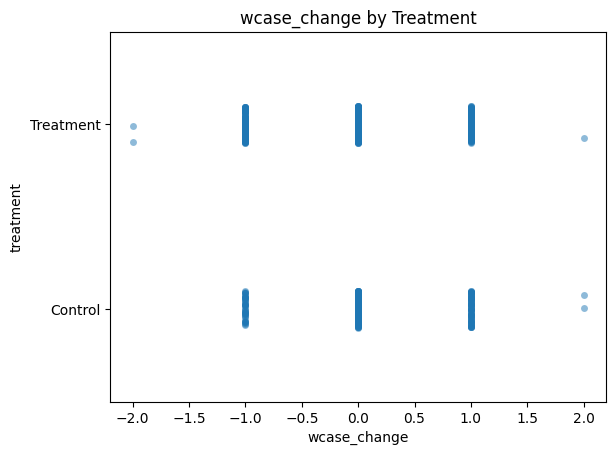

True Average Treatment Effect: -0.4885529426402879


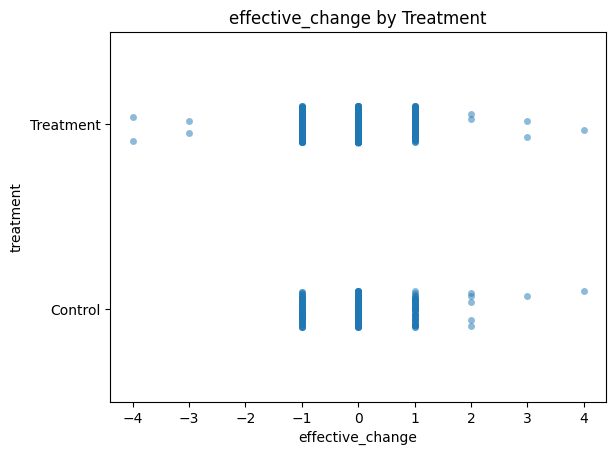

True Average Treatment Effect: -0.4885529426402879


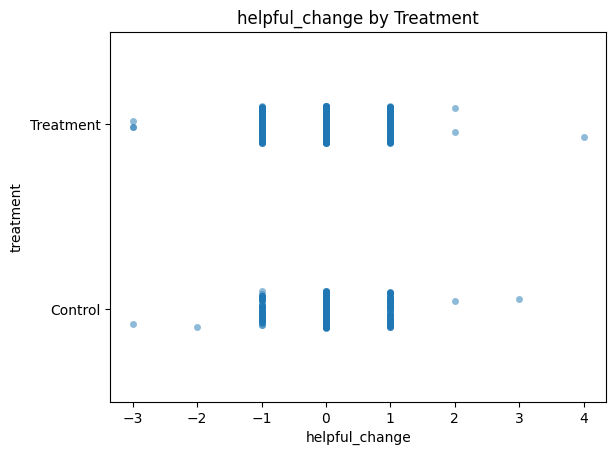

True Average Treatment Effect: -0.4885529426402879


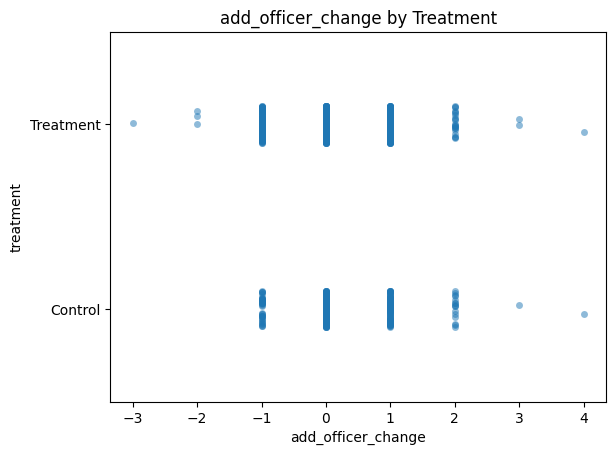

True Average Treatment Effect: -0.4885529426402879


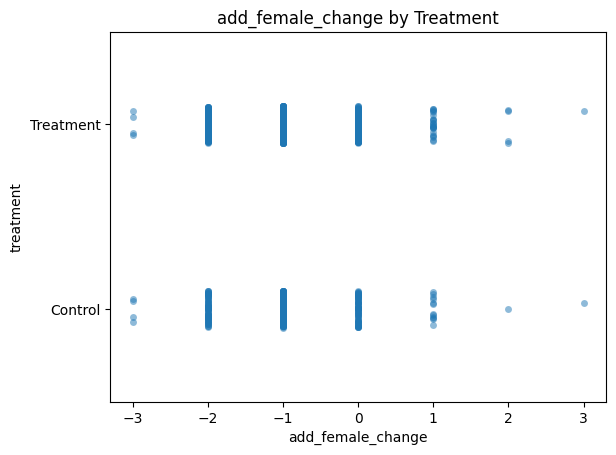

True Average Treatment Effect: -0.4885529426402879


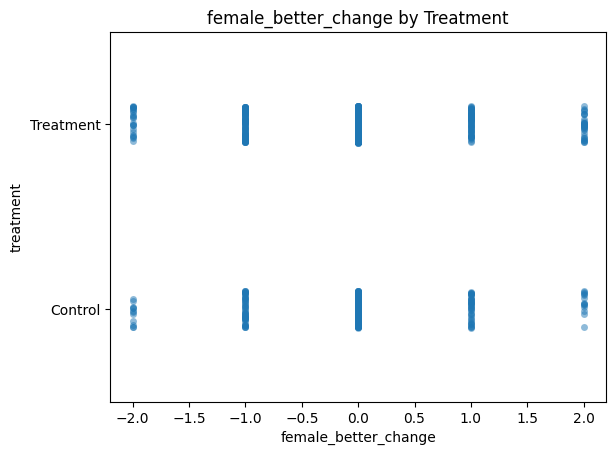

True Average Treatment Effect: -0.4885529426402879


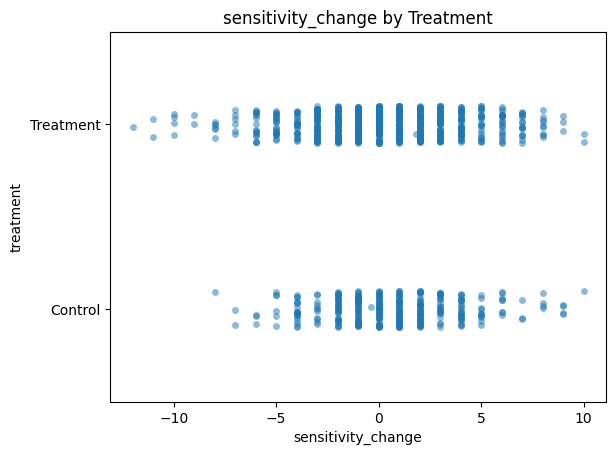

In [45]:
# Get true ATE
for dif in difference_vars:
  true_ate = full_police[full_police['treatment'] == 'Treatment'][dif].mean() - \
                             full_police[full_police['treatment'] == 'Control'][dif].mean()
  print("True Average Treatment Effect:", true_baseline_difference)
  sns.stripplot(x = dif, y = 'treatment', data = full_police, alpha = 0.5)
  plt.title(f"{dif} by Treatment")
  plt.show()
  dif_summary_df.loc[dif,'treatment_mean'] = full_police[full_police['treatment'] == 'Treatment'][dif].mean()
  dif_summary_df.loc[dif,'control_mean'] = full_police[full_police['treatment'] == 'Control'][dif].mean()
  dif_summary_df.loc[dif,'true_ate'] = true_ate

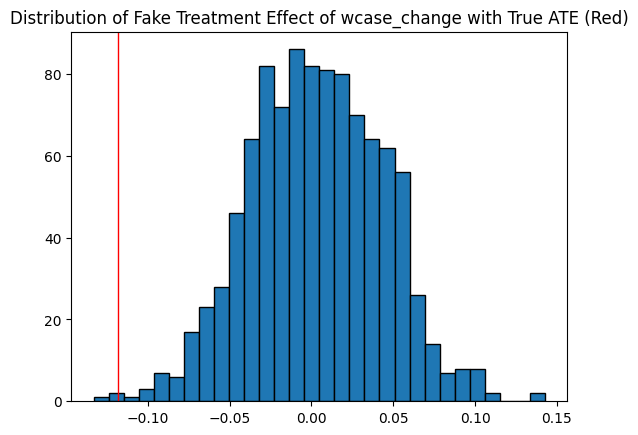

P-value for ATE: 0.005


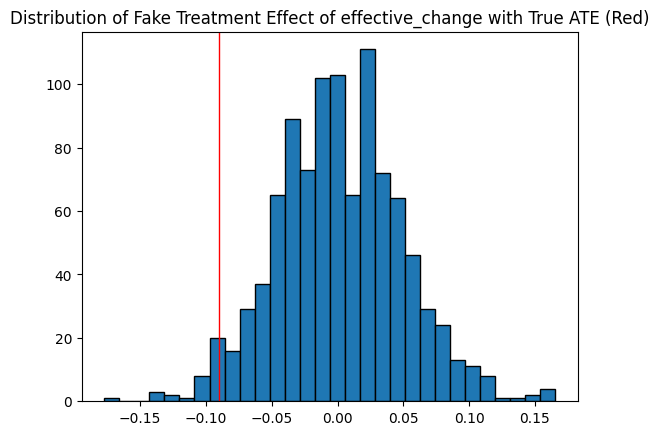

P-value for ATE: 0.059


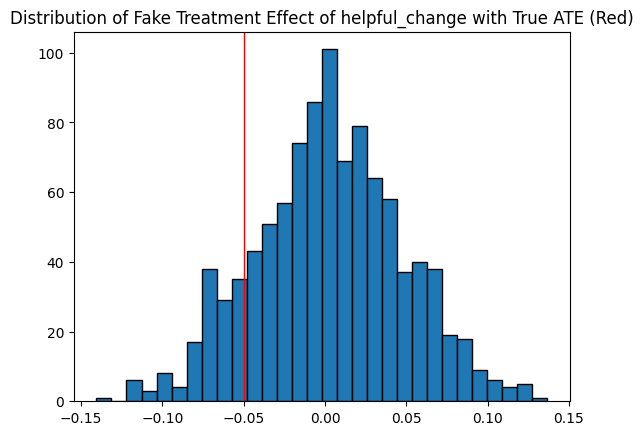

P-value for ATE: 0.293


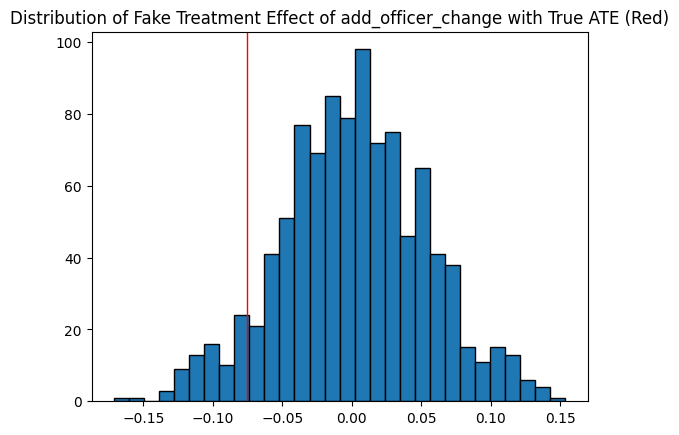

P-value for ATE: 0.151


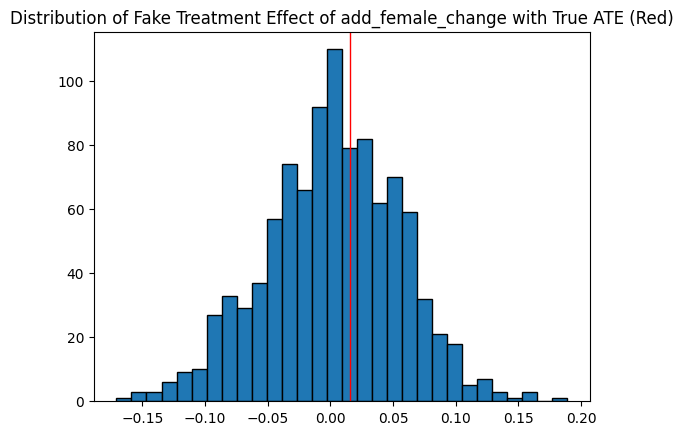

P-value for ATE: 0.749


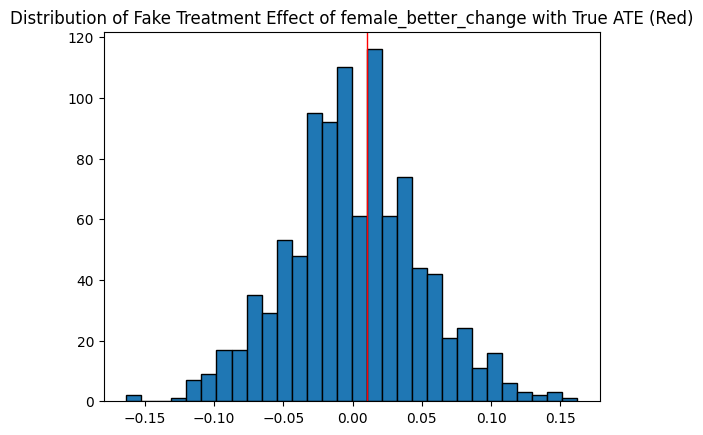

P-value for ATE: 0.854


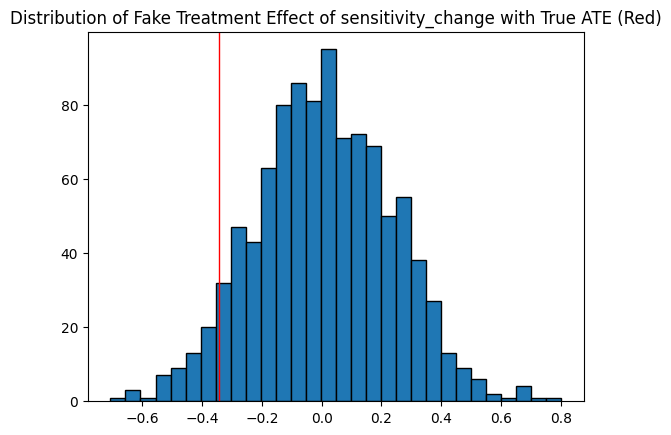

P-value for ATE: 0.13


In [46]:

for dif in difference_vars:
  vector_of_differences = np.empty(1000)    # Make an empty vector to store all our differences
  true_ate = full_police[full_police['treatment'] == 'Treatment'][dif].mean() - \
                             full_police[full_police['treatment'] == 'Control'][dif].mean()

  for i in range(999):
     # Permute the gender labels
     full_police['random_fake_treatment'] = np.random.permutation(full_police['treatment'])
     # Calculate the fake difference and store it in the "ith" spot in the vector
     vector_of_differences[i] = full_police[full_police['random_fake_treatment'] == 'Treatment'][dif].mean() - \
                                full_police[full_police['random_fake_treatment'] == 'Control'][dif].mean()

  # Add real difference to the end of the list
  vector_of_differences[999] = true_ate

  # Plot the distribution of real and fake differences
  plt.hist(vector_of_differences, bins = 30, edgecolor = 'black') # Set up a histogram
  plt.axvline(x = true_ate, color = 'red', linewidth = 1) # Add a vertical red line
  plt.title(f"Distribution of Fake Treatment Effect of {dif} with True ATE (Red)")
  plt.show()
  p_value = (np.abs(vector_of_differences) >= np.abs(true_ate)).mean()
  print("P-value for ATE:", p_value)
  dif_summary_df.loc[dif, 'p-value'] = p_value

In [47]:
dif_summary_df

,treatment_mean,control_mean,true_ate,p-value
variable,,,,
wcase_change,0.000000,0.118343,-0.118343,0.005
effective_change,-0.078404,0.011940,-0.090345,0.059
helpful_change,0.009629,0.059172,-0.049543,0.293
add_officer_change,0.185695,0.261128,-0.075433,0.151
add_female_change,-0.913343,-0.928994,0.015652,0.749
female_better_change,-0.004132,-0.014793,0.010661,0.854
sensitivity_change,0.282329,0.624296,-0.341967,0.130


### Interpreting results of the permutation tests
- Change in perceived police attention to women's cases baseline to endline
  - When we ran our permutation test, we only found a difference as extreme (or more extreme) as our observed result 0.4% of the time, giving us a p-value of 0.004, which falls below a typical decision threshold of 5%. Therefore, we have evidence to **reject the null hypothesis** of no difference between treatment and control, in favor of the alternative: that there is a statistically significant difference in change in officer's perception of police attention to women's cases from baseline to endline, between treatment and control groups
  - Looking at the difference in means, officers in the control group had a larger increase in perceived amount of attention given to cases (highest value option is too much attention) than officers in the treatment group
- Change in perceived police effectiveness in handling women's cases
  - When we ran our permutation test, we found a difference as extreme (or more extreme) as our observed result 6.6% of the time, giving us a p-value of 0.066, which falls just above a typical decision threshold of 5%. Therefore, we **fail to reject the null hypothesis** of no difference between treatment and control in change in officer's perception of police efficacy in women's cases from baseline to endline
  - we failed to reject the null hypothesis here but it was close to significant so I still wanted to call it out
- The rest of the difference variables, we fail to reject the null hypothesis as the p-value is well above 0.05

### Build a linear regression to predict change in perception of police attention to women's cases, utilizing officer and station level features
- linear regression because we are predicting a numerical variable - gets tricky because it is not continuous
- still going to try because ideally would like to be able to interpret incremental affects of the variables on change (eg: an officer being in an urban station rather than rural is associated with an xx increase in officer perception of attention paid to women's cases, holding all else equal)
- might be worth trying a form of classification or ordinal logistic regression as well

In [48]:
# explore possible features
full_police.head(1)

,uid,gender,e_wcase,e_effective,e_false_case,e_helpful,e_add_officer,e_add_female,e_female_better,e_taken_seriously,e_prof_dev,e_work_help,e_pol_impt,e_thana_impt,e_sensitivity,ps_code,population,urban,dist_urban,strat_pca,treatment,group,dist_id,implement_quality,training_score,comm_outreach_strength,regular_whd,women_whd,b_wcase,b_effective,b_pol_impt,b_thana_impt,b_sensitivity,b_helpful,b_female_better,b_add_officer,b_add_female,e_wcase_too little attention,e_wcase_too much attention,e_effective_ineffective,e_effective_very effective,e_effective_very ineffective,e_false_case_uncommon,e_false_case_very common,e_false_case_very uncommon,e_taken_seriously_disagree,e_taken_seriously_strongly agree,e_taken_seriously_strongly disagree,e_prof_dev_disagree,e_prof_dev_strongly agree,e_prof_dev_strongly disagree,e_work_help_disagree,e_work_help_strongly agree,e_work_help_strongly disagree,e_helpful_unhelpful,e_helpful_very helpful,e_helpful_very unhelpful,e_add_officer_more effective,e_add_officer_much more effective,e_add_female_More Effective,e_add_female_Much more effective,e_add_female_No difference,e_female_better_male,e_female_better_no difference,urban_Urban,treatment_Treatment,orig_b_uid,orig_b_pol_impt,orig_b_thana_impt,orig_b_wcase,orig_b_effective,orig_b_helpful,orig_b_add_officer,orig_b_add_female,orig_b_female_better,orig_b_sensitivity,orig_b_wcase_too little attention,orig_b_wcase_too much attention,orig_b_effective_ineffective,orig_b_effective_neither effective nor ineffective,orig_b_effective_very effective,orig_b_effective_very ineffective,orig_b_helpful_neither helpful nor unhelpful,orig_b_helpful_unhelpful,orig_b_helpful_very helpful,orig_b_helpful_very unhelpful,orig_b_add_officer_more effective,orig_b_add_officer_much less effective,orig_b_add_officer_much more effective,orig_b_add_officer_no difference,orig_b_add_female_more effective,orig_b_add_female_much less effective,orig_b_add_female_much more effective,orig_b_add_female_no difference,orig_b_female_better_male,orig_b_female_better_no difference,orig_uid,e_total_surveyed,e_female_surveyed,e_male_surveyed,e_total_staff,e_female_staff,e_total_officers,e_female_officers,e_male_staff,e_male_officers,e_female_sho,b_total_staff,b_female_staff,b_male_staff,b_total_officers,b_female_officers,b_male_officers,b_female_sho,e_total_sampled,e_female_sampled,e_male_sampled,b_total_sampled,b_female_sampled,b_male_sampled,b_total_surveyed,b_female_surveyed,b_male_surveyed,e_male_weight,b_male_weight,e_female_weight,b_female_weight,e_wcase_num,e_effective_num,e_false_case_num,e_helpful_num,e_add_officer_num,e_add_female_num,e_female_better_num,e_taken_seriously_num,e_prof_dev_num,e_work_help_num,b_wcase_num,b_effective_num,b_helpful_num,b_add_officer_num,b_add_female_num,b_female_better_num,wcase_change,effective_change,helpful_change,add_officer_change,add_female_change,female_better_change,sensitivity_change,random_fake_treatment
0,2141733,male,too much attention,very effective,uncommon,very helpful,much more effective,Less effective,female,strongly agree,agree,agree,True,True,8.0,2011,58432,Rural,2.0,-1.332458,Treatment,women officers,2000,9.0,3.77907,2.16,False,True,2.0,5.0,False,False,8.0,4.0,3.0,4.0,5.0,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,2141762,False,False,enough attention,very effective,helpful,more effective,much less effective,female,8.0,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,2141733,12.0,0.0,12.0,43.0,3.0,10.0,1.0,40.0,9.0,False,24.0,0.0,24.0,7.0,0.0,7.0,False,12.0,0.0,12.0,12.0,0.0,12.0,12.0,0.0,12.0,3.333333,2.0,NaN,NaN,3.0,5.0,2.0,5.0,5.0,4.0,3.0,4.0,3.0,3.0,2.0,5.0,4.0,4,5,3.0,1.0,0.0,1.0,1.0,-1.0,0.0,0.0,Treatment


In [49]:
# create list of desired x variables
raw_features = ['gender', 'population', 'urban', 'regular_whd', 'women_whd', 'b_total_officers', 'b_female_officers']

# make dataset with only y and x variables
linear_mod_data = full_police[raw_features + ['wcase_change']]
# check for null values
linear_mod_data.isnull().sum()

,0
gender,0
population,0
urban,0
regular_whd,0
women_whd,0
b_total_officers,0
b_female_officers,0
wcase_change,9


In [50]:
def pct_female_officers(row):
  """
  given a row of a dataframe with total officers and female officers, return percentage of female officers

  Arguments:
    row: row of a Pandas DataFrame

  Return:
    float % of female officers
  """
  if row['b_total_officers'] != 0:
    return row['b_female_officers']/row['b_total_officers']
  else:
    return 0

In [51]:
# Preprocessing

# drop nulls
print(len(linear_mod_data))
linear_mod_data = linear_mod_data.dropna()
linear_mod_data.isnull().sum()

# create % female officers, drop raw # female officers
linear_mod_data['b_pct_female_officers'] = linear_mod_data.apply(pct_female_officers, axis=1)
linear_mod_data.drop('b_female_officers', axis=1, inplace=True)

# convert gender and urban into ints
linear_mod_data['gender'] = linear_mod_data['gender'].apply(lambda x: 1 if 'male' else 0)
linear_mod_data['urban'] = linear_mod_data['urban'].apply(lambda x: 1 if 'Urban' else 0)

print(linear_mod_data.info())

1068
<class 'pandas.core.frame.DataFrame'>
Index: 1059 entries, 0 to 1067
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 1059 non-null   int64  
 1   population             1059 non-null   int64  
 2   urban                  1059 non-null   int64  
 3   regular_whd            1059 non-null   bool   
 4   women_whd              1059 non-null   bool   
 5   b_total_officers       1059 non-null   float64
 6   wcase_change           1059 non-null   float64
 7   b_pct_female_officers  1059 non-null   float64
dtypes: bool(2), float64(3), int64(3)
memory usage: 60.0 KB
None


In [52]:
# set wcase change equal to the data in the wcase_change column
wcase_change = pd.DataFrame(linear_mod_data['wcase_change'])

# set x_vars

X_vars = pd.DataFrame(linear_mod_data.drop('wcase_change', axis=1))


In [53]:
# split the data into training and test sets
wcase_train, wcase_test, X_vars_train, X_vars_test = train_test_split(wcase_change, X_vars, test_size=0.3, random_state=24)

In [54]:
# making the linear regression model

# 1. initialize a LinearRegression model
model3 = LinearRegression()

# 2. fit the model on the training data
model3.fit(X_vars_train, wcase_train)     # fill in training variables for the arguments

# 3. call predict with the flipper_length test data
wcase_predictions = model3.predict(X_vars_test)# call model with argument here



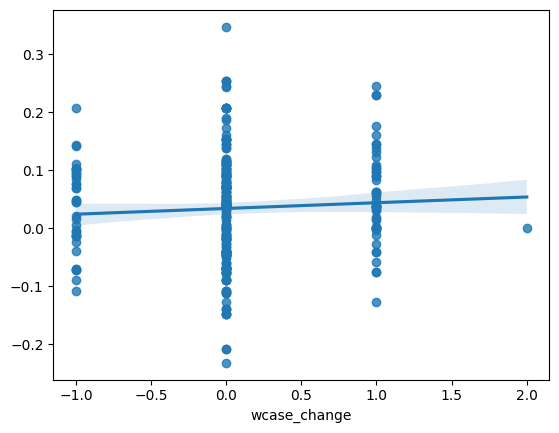

In [55]:
# Look at scatter plot of actual and predictions
_ = sns.regplot(x=wcase_test,
            y=wcase_predictions)

In [56]:
# calculate evaluation metrics
r_squared_train = round(model3.score(X_vars_train, wcase_train) * 100)
r_squared_test = round(model3.score(X_vars_test, wcase_test) * 100)
r_squared_predictions = round(r2_score(wcase_test, wcase_predictions) * 100)
mae = round(mean_absolute_error(wcase_test, wcase_predictions))


print(f"Training Data R-squared: {r_squared_train}%")
print(f"Test Data R-squared: {r_squared_test}%")
print(f"The model's R-squared score: {r_squared_predictions}%")
print(f"Mean Absolute Error: {mae}g")

Training Data R-squared: 2%
Test Data R-squared: -1%
The model's R-squared score: -1%
Mean Absolute Error: 0g


### Model results
- The model is horrible - this isn't surprising, trying to use continuous regression on a variable that only has 4 values
- R-squared (the amount of variance explained by the model) is essentially 0
- do not want to do a classification model though because want to be able to interpret incremental effect of variables on wcase_change

### Next attempt: roll up to station level, taking the mean of wcase_change
- pro: wcase_change no longer only has a few integer values
- pro: most features are station level anyways
- con: lose officer gender as a variable
- con: much less data

In [57]:
#raw_features = ['gender', 'population', 'urban', 'regular_whd', 'women_whd', 'b_total_officers', 'b_female_officers']

# bring in station code
station_modeling_data_raw = pd.concat([linear_mod_data, full_police[~full_police['wcase_change'].isnull()]['ps_code']], axis=1)
print(station_modeling_data_raw.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1059 entries, 0 to 1067
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 1059 non-null   int64  
 1   population             1059 non-null   int64  
 2   urban                  1059 non-null   int64  
 3   regular_whd            1059 non-null   bool   
 4   women_whd              1059 non-null   bool   
 5   b_total_officers       1059 non-null   float64
 6   wcase_change           1059 non-null   float64
 7   b_pct_female_officers  1059 non-null   float64
 8   ps_code                1059 non-null   int64  
dtypes: bool(2), float64(3), int64(4)
memory usage: 68.3 KB
None


In [58]:
# drop officer level gender column
station_modeling_data_raw = station_modeling_data_raw.drop('gender', axis = 1)
#agg to station level, taking the mean of all variables - all station level variables should remain the same, currently are duplicates
station_modeling_data = station_modeling_data_raw.groupby('ps_code').mean()
print(len(station_modeling_data))
station_modeling_data.head()
# only 180 rows to work with now

180


,population,urban,regular_whd,women_whd,b_total_officers,wcase_change,b_pct_female_officers
ps_code,,,,,,,
1001,129345.0,1.0,0.0,1.0,10.0,-0.333333,0.000000
1002,170000.0,1.0,0.0,0.0,7.0,0.200000,0.142857
1003,102467.0,1.0,0.0,0.0,12.0,0.333333,0.166667
1004,54000.0,1.0,1.0,0.0,4.0,0.250000,0.250000
1005,76376.0,1.0,0.0,1.0,6.0,0.000000,0.000000


In [59]:
# set wcase change equal to the data in the wcase_change column
avg_wcase_change = pd.DataFrame(station_modeling_data['wcase_change'])

# set x_vars

X_vars2 = pd.DataFrame(station_modeling_data.drop('wcase_change', axis=1))


In [60]:
# making the linear regression model

# 1. initialize a LinearRegression model
model4 = LinearRegression()

# 2. fit the model on the training data
model4.fit(X_vars2, avg_wcase_change)     # fill in training variables for the arguments

# 3. call predict with the flipper_length test data
wcase_predictions2 = model4.predict(X_vars2)# call model with argument here



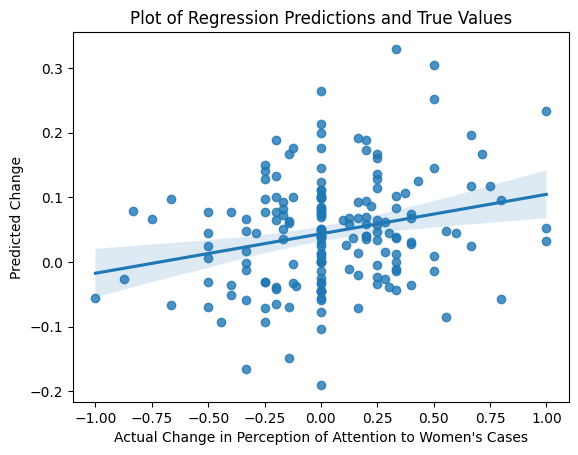

In [62]:
# Look at scatter plot of actual and predictions
_ = sns.regplot(x=avg_wcase_change,
            y=wcase_predictions2)
_ = plt.xlabel("Actual Change in Perception of Attention to Women's Cases")
_ = plt.ylabel("Predicted Change")
_ = plt.title("Plot of Regression Predictions and True Values")

In [64]:
# calculate evaluation metrics
r_squared = round(model4.score(X_vars2, avg_wcase_change) * 100)
r_squared_predictions = round(r2_score(avg_wcase_change, wcase_predictions2) * 100)
mae = round(mean_absolute_error(avg_wcase_change, wcase_predictions2))


print(f"Training Data R-squared: {r_squared_train}%")
print(f"The model's R-squared score: {r_squared_predictions}%")
print(f"Mean Absolute Error: {mae}g")

Training Data R-squared: 2%
The model's R-squared score: 6%
Mean Absolute Error: 0g


### Station Level model attempt thoughts:
- the actual values of change in wcase are more spread out and no longer just a few values
- the model still looks to be performing practically at random
- would like to look at coefficients & p-values to see if any of them seem to have a significant effect
- this model result does not necessarily mean that the change in wcase cannot be predicted from these variables with any accuracy
  - linear regression may not be the right model type for this data
  - we only have 180 rows of data (only trained on 126 bc of train/test split) if the effects are small it is likely they could not be picked up on in this size data

### Next steps:
- try different model types for predicting change in officer's perception of police attention paid to women's cases
  - maybe organize into increase, decrease, no change categories and do classification model
  - ordinal logistic regression
- I still want to try an uplift model but I am discouraged by the data so far (quantity of records, quantity of viable features, size of treatment effect)
  - may give it a go, if I do will use CausalML
  - may bring in additional data (eg: CAW rate, # of arrests, # of filings) if there is a more pronounced treatment effect, although overall I would like to keep to my story about officer perceptions